https://github.com/qubvel/segmentation_models

In [0]:
!pip install git+https://github.com/qubvel/segmentation_models.git

  Cloning https://github.com/qubvel/segmentation_models.git to /tmp/pip-req-build-k69vtg38
  Running command git clone -q https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-k69vtg38
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 81kB 9.4MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-7zp23pz9/wheels/d6/18/c4/340b3ee7253119ec907ec8cf93bd2c572ee9a75eedb183b2f8
Successfully built segmentation-models


Get the data sets

In [0]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import h5py
from skimage import img_as_float
import random

In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
img_path = r'/content/drive/My Drive/Colab Notebooks/datasets/small_images'
msk_path = r'/content/drive/My Drive/Colab Notebooks/datasets/small_masks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
images = os.listdir(img_path)
random.shuffle(images)

# lists to store arrays
X_list = []
Y_list = []

# we need to make them all the same size
idx = 0
for img in images:
    try:
        # get the original image
        with Image.open(os.path.join(img_path, img)) as original:        
            # make the image smaller and append to the list
            X_list.append(np.array(img_as_float(original)))
        
        # get the corresponding mask and append to the Y_list
        with Image.open(os.path.join(msk_path, os.path.splitext(img)[0] + '_segmentation.png')) as mask:
            mask = np.array(img_as_float(mask))
            temp = np.ndarray(list(mask.shape)+[1], dtype=float)
            temp[:, :, 0] = mask
            Y_list.append(temp)
        
        # display progress
        if idx % 100 == 0:
            print('{:.0%} . '.format(idx/float(len(images))), end="")

        idx += 1
        
    except Exception as e:
        
        print('whoopsie!', e)
np.array(Y_list).shape

0% . 4% . 8% . 12% . 15% . 19% . 23% . 27% . 31% . 35% . 39% . 42% . 46% . 50% . 54% . 58% . 62% . 66% . 69% . 73% . 77% . 81% . 85% . 89% . 93% . 96% . 

(2594, 128, 128, 1)

In [0]:
# lets do an 60:20:20 split on training, validation and testing
train = int(len(X_list)*0.6)
valid = int(len(X_list)*0.8)
X = np.array(X_list)

print(X.shape)

Y = np.array(Y_list)

print(Y.shape)

# get training, validation and test sets
# inputs
x_train = X[:train]
x_val = X[train:valid]

# labels
y_train = Y[:train]
y_val = Y[train:valid]

# output the test sets to a csv
test_images = pd.DataFrame(images[valid:], columns=['image'])
test_images.to_csv(r'/content/drive/My Drive/Colab Notebooks/datasets/test_images.csv')
test_images.head()

(2594, 128, 128, 3)
(2594, 128, 128, 1)


,image
0,ISIC_0012278.jpg
1,ISIC_0011121.jpg
2,ISIC_0010015.jpg
3,ISIC_0014698.jpg
4,ISIC_0000397.jpg


In [0]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from keras.callbacks import ReduceLROnPlateau

BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

# load your data

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

# lets set a callback function to reduce the learning rate as the lass begins to plateau
red_lrn = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# fit model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[red_lrn]
)

Train on 1556 samples, validate on 519 samples
Epoch 1/100
1556/1556 [==============================] - 19s 12ms/step - loss: 0.8204 - iou_score: 0.4811 - val_loss: 0.8135 - val_iou_score: 0.6493
Epoch 2/100
1556/1556 [==============================] - 9s 6ms/step - loss: 0.5116 - iou_score: 0.6849 - val_loss: 0.6008 - val_iou_score: 0.7195
Epoch 3/100
1556/1556 [==============================] - 9s 6ms/step - loss: 0.4432 - iou_score: 0.7383 - val_loss: 0.5597 - val_iou_score: 0.7409
Epoch 4/100
1556/1556 [==============================] - 10s 6ms/step - loss: 0.4282 - iou_score: 0.7506 - val_loss: 0.7415 - val_iou_score: 0.6166
Epoch 5/100
1556/1556 [==============================] - 10s 6ms/step - loss: 0.4082 - iou_score: 0.7609 - val_loss: 0.4403 - val_iou_score: 0.7571
Epoch 6/100
1556/1556 [==============================] - 10s 6ms/step - loss: 0.3567 - iou_score: 0.7879 - val_loss: 0.4489 - val_iou_score: 0.7578
Epoch 7/100
1556/1556 [==============================] - 10s 6ms/s

In [0]:
# model.save(r'/content/drive/My Drive/Colab Notebooks/models/segmentation/mole_seg.h5')

In [0]:
def return_change(lr):
    diff = [v0 - v1 for v0, v1 in zip(lr[:-1],lr[1:])]
    changes = [0]
    for i in range(len(diff)):
        if diff[i] > 0.0:
            changes.append(i)
    return changes

In [0]:
label_style = dict(horizontalalignment='left',
                  verticalalignment='bottom',
                  rotation=90, alpha=0.5, fontsize=12)
line = dict(linewidth=0.5, linestyle='--', color='black', alpha=0.5)
axis_style = dict()

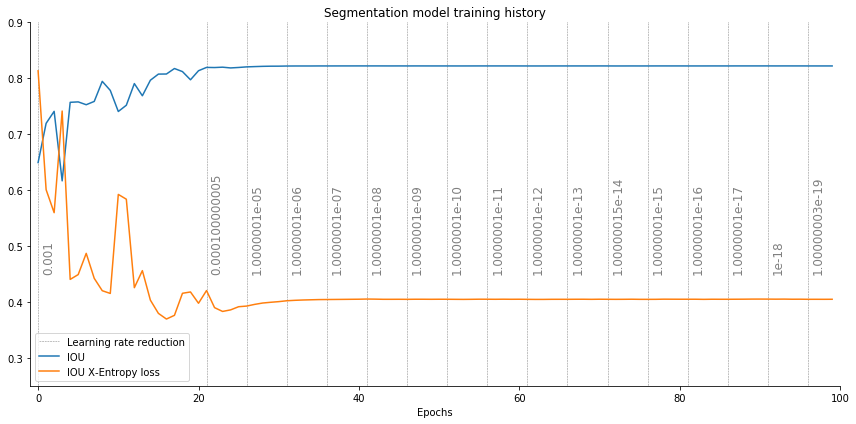

In [0]:
import seaborn as sns
from matplotlib.lines import Line2D

# plot the validation loss and iou, include the learning rate reductions
fig, ax = plt.subplots(figsize=[12,6])

# validation values
iou = history.history['val_iou_score']
loss = history.history['val_loss']
x = range(len(iou))

# what are the unique learning rates and where do they occur? 
lr = history.history['lr']
ulr = list(set(lr))
ulr.sort(reverse=True)
changes = return_change(lr)

# create a line and a label for each change
for chi, lr_ in zip(changes, ulr):
    ax.add_line(Line2D([chi, chi], [0, 1], **line))
    ax.text(chi + 0.5, 0.45, lr_, **label_style)
    
ax.add_line(Line2D([-1,-1], [-1,-1], label="Learning rate reduction", **line))
plt.ylim([0.25, 0.9])
sns.lineplot(x=x, y=iou, label='IOU')
sns.lineplot(x=x, y=loss, label='IOU X-Entropy loss')
plt.ylim([0.25, 0.9])
plt.xlim([-1, 100])
plt.xlabel("Epochs")
plt.title("Segmentation model training history")
# plt.ylabel("IOU and Loss")
sns.despine()
plt.tight_layout()
plt.savefig(r'/content/drive/My Drive/Colab Notebooks/seg_history.jpg')